In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt
from datetime import date
today = date.today()
from tqdm import tqdm
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn
from wordcloud import WordCloud
import string
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
import gensim
from itertools import combinations
from sklearn.tree import DecisionTreeClassifier
from util import *
import joblib
from scipy.sparse import csc_matrix

In [ ]:
#Lecture du Fichier
#df = pd.read_csv('posts_after_prepocessing.csv', sep = ',', encoding='UTF-8')

In [4]:
#Deserialisation de mon Dataframe traité côté Preprocessing
import pickle
with open('df_afterPreprocessing.pickle', 'rb') as file:
    df = pickle.load(file)

In [5]:
#Préprocessing du champ Tittle et Body
df['TitleBody'] = df['TitleBody'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
df['TitleBody'] = df['TitleBody'].map(lambda x: x.replace('\n', ' '))
df['TitleBody'] = df['TitleBody'].map(lambda x: x.replace(':', ''))

punct = string.punctuation
for c in punct:
    if c != '#':
        df['TitleBody'] = df['TitleBody'].map(lambda x: x.replace(c, ''))

#Parsing avec NLTK
df['TitleBody_final'] = df.apply(lambda row: nltk.word_tokenize(row['TitleBody'],language='english'), axis=1)

#Supression des StopWord
df['TitleBody_final'] = df.apply(lambda row:removeStopWord(row['TitleBody_final']), axis=1)

#Lemmatisation
#df['TitleBody_final'] = df.apply(lambda row:lemmatisation(row['TitleBody_final']), axis=1)

#Traitement du C#
df['TitleBody_final'] = df.apply(lambda row:processCSharp(row['TitleBody_final']), axis=1)

#Suppressin des numériques
df['TitleBody_final'] = df.apply(lambda row:removeOnlyNumeric(row['TitleBody_final']), axis=1)

In [6]:
#Suppression des tags similaires
df['processed_tags_final2'] = df.apply(lambda row:removeTagSimilaire(row['processed_tags_final']), axis=1)

In [11]:
df.head(2)

,Id,BODY,Title,Tags,CreationDate,TitleBody,processed_tags_final,processed_body_final,processed_title_final,tags_words,TitleBody_final,processed_tags_final2
0,12051,<p>if i inherit from a base class and want to ...,calling the base constructor in c#,<c#><.net><inheritance><constructor>,2008-08-15 07:39:23,calling the base constructor in c# if i inheri...,"[c#, .net]","[inherit, base, class, want, pass, something, ...","[calling, base, constructor, c#]","[c#, .net, inheritance, constructor]","[calling, base, constructor, c#, inherit, base...","[c#, .net]"
1,17319422,<p>i am using pycharm on windows and want to c...,how do i set the maximum line length in pycharm?,<python><pycharm><pep8>,2013-06-26 12:00:31,how do i set the maximum line length in pychar...,[python],"[using, pycharm, windows, want, change, settin...","[set, maximum, line, length, pycharm]","[python, pycharm, pep8]","[set, maximum, line, length, pycharm, using, p...",[python]


In [12]:
df.iloc[1,2]

'how do i set the maximum line length in pycharm?'

In [14]:
#Utilisation de la librairie MultilabelBinarize pour créer un matrice de Tags
from sklearn.preprocessing import MultiLabelBinarizer

tags = df["processed_tags_final2"]

mlb = MultiLabelBinarizer()
tags_mlb = mlb.fit_transform(df["processed_tags_final2"].to_numpy())

In [112]:
#Serialisation avec JOBLIB
joblib.dump(mlb,"multiLabel.pickle")

['multiLabel.pickle']

## Création du jeu d'entrainement et du jeu de test 

In [15]:
from sklearn.model_selection import train_test_split

X = df['TitleBody_final']
y = tags_mlb

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.25)

## Vectorisation avec TF-IDF

In [16]:
vectorizer = TfidfVectorizer(tokenizer=dummy,preprocessor=dummy,
                            max_features=12000)
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

C:\Users\jerom\anaconda3\envs\PROJET5\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
#Serialisation de la vectorisation
pickle.dump(vectorizer, open('vectorizer.pickle', 'wb')) #Saving DF

In [111]:
#Serialisation avec JOBLIB
joblib.dump(vectorizer,"vectorizer.pickle")

['vectorizer.pickle']

In [34]:
X_train_vec.shape

(11378, 12000)

## Modèle Naive Bayse après TF_IDF
* Utilisation de la méthode OneVsRest qui calcule toutes les étiquettes de sortie (Attention aux performances car n modèles suivant les tags de sortie)
* J'utilise les données après un TF_IDF

In [7]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

nb_clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, 
                                           class_prior=None))
nb_clf.fit(X_train_vec, y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [8]:
y_pred_nb = nb_clf.predict(X_test_vec)
print_score(y_test, y_pred_nb)

Hamming loss : 0.01577643026627999
Subset Accuracy :  0.04323754284207751
F1-score :  0.08445532435740516
Jaccard :  0.044089456869009586


## Modèle Arbre de décision après NMF (Comme réduction de dimension)

In [9]:
#D'abord réalisation d'une NMF avec le paramètre optimum calculté précédemment (8 Topics)
from sklearn.decomposition import NMF
k = 8
# create the model, specifiying the initialization strategy and the number of topics to produce
model = NMF(n_components=k,init="nndsvd",random_state=42,max_iter = 300) 
# apply the model and extract the two factor matrices
W_train = model.fit_transform(X_train_vec)
W_test = model.fit_transform(X_test_vec)

In [10]:
#Arbre de décision
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(W_train, y_train)

DecisionTreeClassifier(random_state=0)

In [11]:
y_pred_nb = clf.predict(W_test)
print_score(y_test, y_pred_nb)

Hamming loss : 0.030925388874242024
Subset Accuracy :  0.04007382019509623
F1-score :  0.11257376305038584
Jaccard :  0.059644059644059645


## Modèle Arbre de décision après TF-IDF

In [17]:
#Arbre de décision
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_vec, y_train)

DecisionTreeClassifier(random_state=42)

In [18]:
y_pred_nb = clf.predict(X_test_vec)
print_score(y_test, y_pred_nb)

Hamming loss : 0.013831965848839037
Subset Accuracy :  0.3329818085947799
F1-score :  0.5620573355817875
Jaccard :  0.3908760408115398


In [106]:
#Serialisation du modele
pickle.dump(clf, open('decisionTreeClassifier.pickle', 'wb')) #Saving DF

In [113]:
#Serialisation avec JOBLIB
joblib.dump(clf,"decisionTreeClassifier.pickle")

['decisionTreeClassifier.pickle']

In [115]:
df['TitleBody'][9]

'how do you generate dynamic parameterized unit tests in python i have some kind of test data and want to create a unit test for each item my first idea was to do it like this import unittest  l  foo a a bar a b lee b b  class testsequenceunittesttestcase     def testsampleself         for name ab in l             print test name             selfassertequalab  if name  main     unittestmain  the downside of this is that it handles all data in one test i would like to generate one test for each item on the fly any suggestions '

In [103]:
X_api_vec = vectorizer.transform(X[1])
res = clf.predict(X_api_vec)
res = mlb.inverse_transform(res)
comptagePrediction = {}
for x in res:
    for i in x:
        if (i in comptagePrediction):
            comptagePrediction[i] = comptagePrediction[i]+1
        else:
            comptagePrediction[i] = 1

comptagePrediction = sorted(comptagePrediction.items(), key=lambda prediction: prediction[1],reverse=True)

print("My tags", list(set(dict(comptagePrediction[0:3]).keys())))

My tags ['arrays', 'c++', 'algorithm']


In [110]:
print(X[1])
print("prediction")
print(comptagePrediction)

['set', 'maximum', 'line', 'length', 'pycharm', 'using', 'pycharm', 'windows', 'want', 'change', 'settings', 'limit', 'maximum', 'line', 'length', 'characters', 'opposed', 'default', 'limit', 'characters', 'change', 'maximum', 'amount', 'characters', 'per', 'line', 'pycharm']
prediction
[('algorithm', 10), ('arrays', 10), ('c++', 10), ('r', 4), ('python', 3), ('c', 3)]


## Modèle Arbre de décision après TruncateSVD
* Contrairement à l'ACP TruncateSVD supporte les matrices creuses

In [14]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
svd.fit(X_train_vec)
X_train_SVD = svd.transform(X_train_vec)
X_test_SVD = svd.transform(X_test_vec)

#Arbre de décision
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_SVD, y_train)

DecisionTreeClassifier(random_state=42)

In [15]:
y_pred_nb = clf.predict(X_test_SVD)
print_score(y_test, y_pred_nb)

Hamming loss : 0.021523859741629316
Subset Accuracy :  0.16530450830477195
F1-score :  0.35031036129237625
Jaccard :  0.21234925229136517


In [ ]:
X_train_vec.shape

## Modèle Arbre de décision après ACP

In [16]:
from sklearn import decomposition
# choix du nombre de composantes à calculer
n_comp = 50

features = df.columns

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp,random_state=42)
pca.fit(X_train_vec.toarray())
X_train_PCA = pca.transform(X_train_vec.toarray())
X_test_PCA = pca.transform(X_test_vec.toarray())

#Arbre de décision
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_PCA, y_train)

DecisionTreeClassifier(random_state=42)

In [17]:
y_pred_nb = clf.predict(X_test_PCA)
print_score(y_test, y_pred_nb)

Hamming loss : 0.02165568151858687
Subset Accuracy :  0.16293171631953599
F1-score :  0.3483021263091083
Jaccard :  0.2108752041502546


In [13]:
mlb.classes_

array(['.net', 'ajax', 'algorithm', 'android', 'android-studio',
       'angular', 'arrays', 'asp.net', 'bash', 'branch', 'c', 'c#', 'c++',
       'class', 'cocoa-touch', 'collections', 'command-line', 'css',
       'database', 'dataframe', 'date', 'debugging', 'dictionary',
       'django', 'docker', 'dom', 'eclipse', 'exception', 'file', 'forms',
       'function', 'generics', 'git', 'go', 'google-chrome', 'html',
       'http', 'intellij-idea', 'ios', 'iphone', 'java', 'javascript',
       'jquery', 'json', 'language-agnostic', 'linq', 'linux', 'list',
       'loops', 'macos', 'matplotlib', 'mongodb', 'multithreading',
       'mysql', 'node.js', 'npm', 'numpy', 'object', 'objective-c', 'oop',
       'pandas', 'performance', 'php', 'postgresql', 'python', 'r',
       'reactjs', 'regex', 'rest', 'ruby', 'ruby-on-rails', 'security',
       'shell', 'sorting', 'sql', 'sql-server', 'string', 'swift',
       'syntax', 'tsql', 'twitter-bootstrap', 'typescript',
       'unit-testing', 'unix

In [12]:
#Fonction qui compte les bonnes prédictions et les mauvaises prédictions par tags
def scoreTags():
    resultat = []
    for index, word in enumerate(mlb.classes_):
        GoodPrediction = 0
        BadPrediction = 0
        GoodNegative = 0
        BadNegative = 0
        for i in range(0,len(y_test)):
            if (y_test[i][index] == 1):
                if (y_test[i][index] == y_pred_nb[i][index]):
                    GoodPrediction += 1
                else:
                    BadPrediction +=1
            else :
                if (y_test[i][index] == y_pred_nb[i][index]):
                    GoodNegative += 1
                else:
                    BadNegative +=1
        resultat.append([word,GoodPrediction,BadPrediction,GoodNegative,BadNegative])
    return resultat

In [13]:
comptagePrediction = scoreTags()
comptagePrediction = sorted(comptagePrediction, key=lambda prediction: prediction[1],reverse=True)

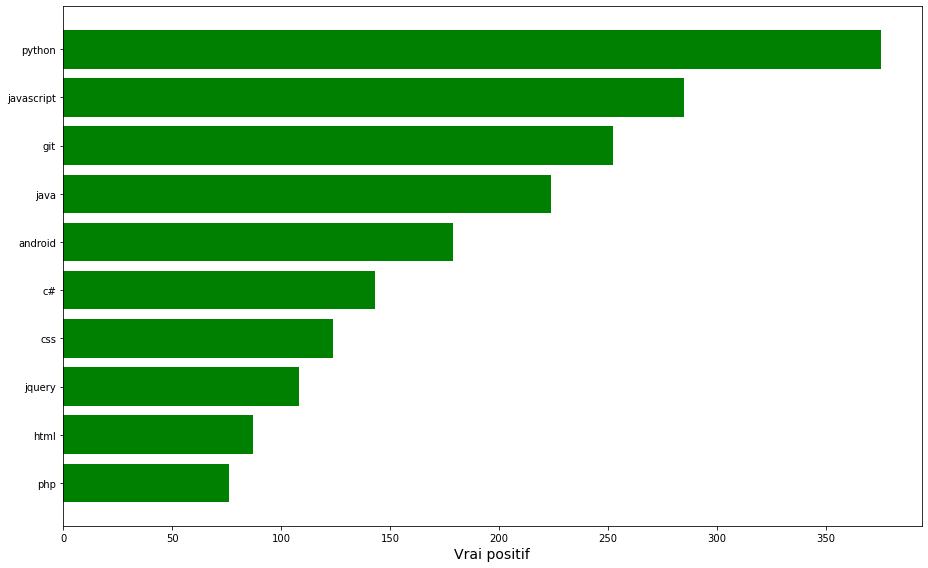

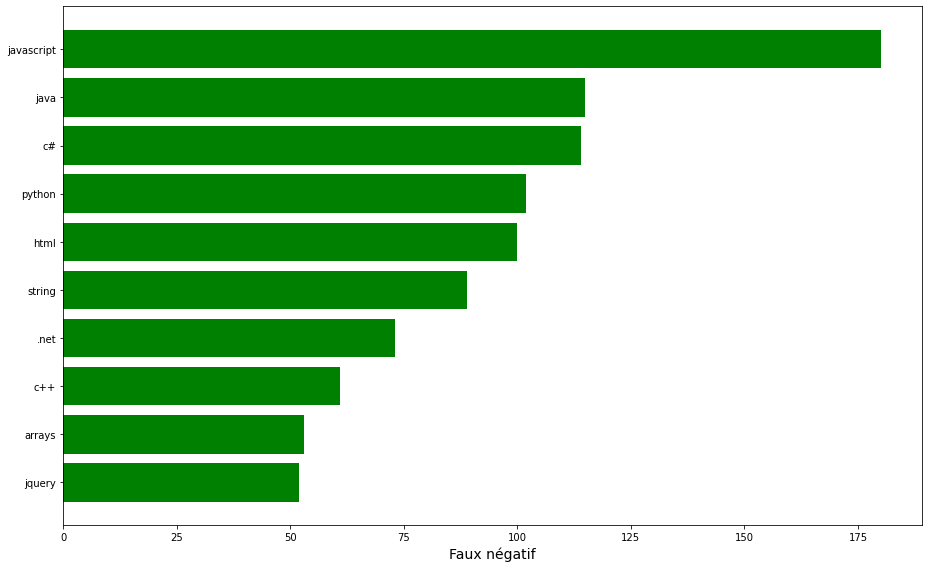

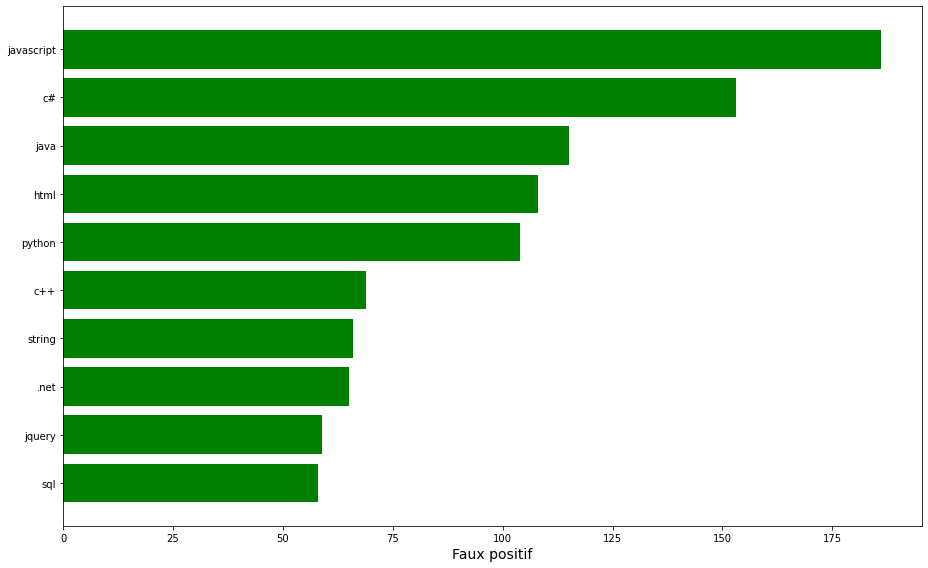

In [16]:
def plot_top_term(comptage,indice,titre):
    top = 10
    trieTerme = []
    # get the top terms and their weights
    trieTerme = sorted(comptagePrediction, key=lambda prediction: prediction[indice],reverse=True)
    top_terms = []
    top_weights = []
    for term_index in trieTerme[0:top]:
        top_terms.append( term_index[0] )
        top_weights.append( term_index[indice] )
    top_terms.reverse()
    top_weights.reverse()
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(len(top_terms))
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel(titre,fontsize=14)
    plt.tight_layout()
    plt.show()
    
plot_top_term(comptagePrediction,1,'Vrai positif')
plot_top_term(comptagePrediction,2,'Faux négatif')
plot_top_term(comptagePrediction,4,'Faux positif')